## Convolutional Neural Networks

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](https://medium.com/@alexattia18) (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://drive.google.com/drive/folders/171GKxRx2SCjLfcfYSPbIa1HzpR6ha3-s?usp=sharing) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://drive.google.com/drive/folders/1B4L6Pk1x9cbfvbP1uQTBSD959_n3QdvL?usp=sharing) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.

Todo el dataset en un solo enlace([Enlace_descarga_completo](https://drive.google.com/file/d/1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La/view?usp=sharing))


<div align='center'>
    
# Evaluación Parcial N°2: Clasificador Simpsonms - Redes Convulcionales

</div>

# Dataset: Simpsons

**Estudiante:** Joaquin Calderon, Matias Raipane

**Profesor:** Giocrisrai Godoy

**Asignatura:** Deep Learning

**Sección:** 001D


## Carga de los datos

In [1]:
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shutil
import random
import tempfile
import subprocess

from tensorflow import keras
import tensorflow as tf

from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import itertools
import glob
from pathlib import Path
from PIL import Image
import datetime
import time

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Ruta base en Drive
DRIVE_BASE_PATH = "/content/drive/MyDrive/DataSets/Deep/Simpsons"

# Crear carpetas en Drive
!mkdir -p "$DRIVE_BASE_PATH"

# Descargar y mover archivo ZIP al Drive
#!gdown 1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La -O "$DRIVE_BASE_PATH/archive.zip"
!unzip -q "$DRIVE_BASE_PATH/archive.zip" -d "$DRIVE_BASE_PATH"

# Verificar
!ls -la "$DRIVE_BASE_PATH"

# Nuevas rutas para entrenamiento y test
DATASET_TRAIN_PATH = f"{DRIVE_BASE_PATH}/simpsons_dataset"
DATASET_TEST_PATH = f"{DRIVE_BASE_PATH}/kaggle_simpson_testset"

# Verificar que las carpetas existen
print(f"\nCarpeta de entrenamiento existe: {os.path.exists(DATASET_TRAIN_PATH)}")
print(f"Carpeta de prueba existe: {os.path.exists(DATASET_TEST_PATH)}")

# Contar personajes y mostrar estadísticas si las carpetas existen
if os.path.exists(DATASET_TRAIN_PATH):
    # Comprobar si hay subcarpetas (personajes)
    if any(os.path.isdir(os.path.join(DATASET_TRAIN_PATH, f)) for f in os.listdir(DATASET_TRAIN_PATH)):
        train_classes = [d for d in os.listdir(DATASET_TRAIN_PATH) if os.path.isdir(os.path.join(DATASET_TRAIN_PATH, d))]
        print(f"\nNúmero de personajes en el dataset de entrenamiento: {len(train_classes)}")
        print(f"Ejemplos de personajes: {train_classes[:5]}")

        # Contar imágenes por personaje
        train_images_count = {}
        total_train_images = 0

        for character in train_classes:
            char_path = os.path.join(DATASET_TRAIN_PATH, character)
            images = [f for f in os.listdir(char_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            train_images_count[character] = len(images)
            total_train_images += len(images)

        print(f"Total de imágenes de entrenamiento: {total_train_images}")
        print("\nPersonajes con más imágenes:")
        for char, count in sorted(train_images_count.items(), key=lambda x: x[1], reverse=True)[:18]:
            print(f"{char}: {count} imágenes")
    else:
        print("La carpeta de entrenamiento no parece contener subdirectorios de personajes.")
        print("Contenido de la carpeta de entrenamiento:")
        !ls -la {DATASET_TRAIN_PATH}

if os.path.exists(DATASET_TEST_PATH):
    # Comprobar si hay subcarpetas (personajes) o si es una estructura plana
    if any(os.path.isdir(os.path.join(DATASET_TEST_PATH, f)) for f in os.listdir(DATASET_TEST_PATH)):
        test_classes = [d for d in os.listdir(DATASET_TEST_PATH) if os.path.isdir(os.path.join(DATASET_TEST_PATH, d))]
        print(f"\nNúmero de personajes en el dataset de prueba: {len(test_classes)}")
        print(f"Ejemplos de personajes: {test_classes[:5]}")

        # Contar imágenes totales en prueba
        test_images = 0
        for cls in test_classes:
            test_images += len(os.listdir(os.path.join(DATASET_TEST_PATH, cls)))
        print(f"Total de imágenes de prueba: {test_images}")
    else:
        # Si no hay subcarpetas, contar directamente las imágenes
        test_images = [f for f in os.listdir(DATASET_TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"\nTotal de imágenes de prueba: {len(test_images)}")

# Ahora puedes continuar con tu código para el modelo de clasificación
print("\nConfiguración completa. Puedes proceder con el entrenamiento del modelo.")

total 1212350
-rw-------  1 root root     491788 Sep 20  2019 annotation.txt
-rw-------  1 root root 1158208931 May 22 20:26 archive.zip
-rw-------  1 root root     598494 Sep 20  2019 characters_illustration.png
drwx------  3 root root       4096 May 22 22:36 kaggle_simpson_testset
-rw-------  1 root root       1452 Sep 20  2019 number_pic_char.csv
drwx------ 45 root root       4096 May 22 22:46 simpsons_dataset
-rw-------  1 root root   82136544 Sep 20  2019 weights.best.hdf5

Carpeta de entrenamiento existe: True
Carpeta de prueba existe: True

Número de personajes en el dataset de entrenamiento: 43
Ejemplos de personajes: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson']
Total de imágenes de entrenamiento: 20933

Personajes con más imágenes:
homer_simpson: 2246 imágenes
ned_flanders: 1454 imágenes
moe_szyslak: 1452 imágenes
lisa_simpson: 1354 imágenes
bart_simpson: 1342 imágenes
marge_simpson: 1291 imágenes
krusty_the_clown: 1206

## Configuración general

In [3]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

IMG_SIZE = (122, 122)
BATCH_SIZE = 100
TARGET_IMAGES = 1200

# Carga de datos

## Balanceo de clases

In [5]:
# Paths
INPUT_DIR = Path("/content/drive/MyDrive/DataSets/Deep/Simpsons/simpsons_dataset")
OUTPUT_DIR = Path("/content/drive/MyDrive/DataSets/Deep/Simpsons/simpson_balanced")

# Aumentación
datagen = ImageDataGenerator(
    rotation_range=30,             # rotación
    width_shift_range=0.2,        # desplazamiento horizontal
    height_shift_range=0.2,       # desplazamiento vertical
    zoom_range=0.1,                # zoom más agresivo
    shear_range=0.1,               # corte más fuerte
    brightness_range=[0.8, 1.2],   # cambio de brillo para luz/día/noche
    horizontal_flip=True,
    fill_mode='nearest'
)

def balance_class(character_name):
    src_path = INPUT_DIR / character_name
    dst_path = OUTPUT_DIR / character_name
    dst_path.mkdir(parents=True, exist_ok=True)

    # Chequear cuántas hay ya en el destino
    current_in_dst = len([f for f in dst_path.glob("*") if f.suffix.lower() in ['.jpg']])
    if current_in_dst >= TARGET_IMAGES:
        print(f"✅ {character_name} ya está balanceado con {current_in_dst} imágenes. Skip.")
        return

    imgs = list(src_path.glob("*"))
    imgs = [img for img in imgs if img.suffix.lower() in ['.jpg']]
    if not imgs:
        print(f"⚠️ {character_name} no tiene imágenes en origen. Skip.")
        return

    # Calcular cuántas faltan
    faltan = TARGET_IMAGES - current_in_dst
    print(f"📊 {character_name}: tiene {current_in_dst}, faltan {faltan}")

    # Copiar imágenes si es necesario
    copied = 0
    for img_path in imgs:
        if copied >= faltan:
            break
        new_path = dst_path / f"original_extra_{copied}{img_path.suffix}"
        if not new_path.exists():
            shutil.copy(img_path, new_path)
            copied += 1

    # Recontar después de copiar
    current_in_dst = len([f for f in dst_path.glob("*") if f.suffix.lower() in ['.jpg']])
    faltan = TARGET_IMAGES - current_in_dst

    if faltan <= 0:
        print(f"✅ {character_name} balanceado a 1200 (con copia solamente)")
        return

    print(f"🛠️ Aumentando {faltan} imágenes para {character_name} en: {dst_path}")

    # Cargar imágenes originales para aumento
    loaded_imgs = []
    for img_path in imgs:
        try:
            img = load_img(img_path, target_size=IMG_SIZE)
            arr = img_to_array(img)
            loaded_imgs.append(arr)
        except:
            continue

    if not loaded_imgs:
        print(f"❌ No se pudieron cargar imágenes para {character_name}. Skip.")
        return

    loaded_imgs = np.array(loaded_imgs)
    gen = datagen.flow(
        loaded_imgs,
        batch_size=1,
        save_to_dir=dst_path,
        save_prefix="aug",
        save_format="jpg"
    )

    for _ in range(faltan):
        next(gen)


# Ejecutar solo para las clases del MAP
for label in MAP_CHARACTERS.values():
    class_path = INPUT_DIR / label
    if class_path.exists():
        balance_class(label)
    else:
        print(f"⚠️ {label} no encontrado en {INPUT_DIR}")

print("✅ Dataset balanceado. Cada clase tiene 1200 imágenes. ")

✅ abraham_grampa_simpson ya está balanceado con 1200 imágenes. Skip.
✅ apu_nahasapeemapetilon ya está balanceado con 1200 imágenes. Skip.
📊 bart_simpson: tiene 985, faltan 215
🛠️ Aumentando 215 imágenes para bart_simpson en: /content/drive/MyDrive/DataSets/Deep/Simpsons/simpson_balanced/bart_simpson
📊 charles_montgomery_burns: tiene 0, faltan 1200
🛠️ Aumentando 7 imágenes para charles_montgomery_burns en: /content/drive/MyDrive/DataSets/Deep/Simpsons/simpson_balanced/charles_montgomery_burns
📊 chief_wiggum: tiene 0, faltan 1200
🛠️ Aumentando 214 imágenes para chief_wiggum en: /content/drive/MyDrive/DataSets/Deep/Simpsons/simpson_balanced/chief_wiggum
📊 comic_book_guy: tiene 0, faltan 1200
🛠️ Aumentando 731 imágenes para comic_book_guy en: /content/drive/MyDrive/DataSets/Deep/Simpsons/simpson_balanced/comic_book_guy
📊 edna_krabappel: tiene 0, faltan 1200
🛠️ Aumentando 743 imágenes para edna_krabappel en: /content/drive/MyDrive/DataSets/Deep/Simpsons/simpson_balanced/edna_krabappel
📊 hom

## Dataset

In [6]:

IMG_SIZE = (64, 64)

# Cargar datasets sin normalizar manualmente
train_ds = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=123,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=123,
    shuffle=True
)


Found 21600 files belonging to 18 classes.
Using 17280 files for training.
Found 21600 files belonging to 18 classes.
Using 4320 files for validation.


In [7]:
class_names = train_ds.class_names
num_classes = len(train_ds.class_names)
print("Clases:", class_names)
print("Número de clases:", num_classes)

Clases: ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'principal_skinner', 'sideshow_bob']
Número de clases: 18


## Test

In [8]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, IMG_SIZE)
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [9]:
# los de los ficheros donde hayas descargado los datos.
DATASET_TEST_PATH_COLAB = "/content/drive/MyDrive/DataSets/Deep/Simpsons/kaggle_simpson_testset/kaggle_simpson_testset"

X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leídas 890 imágenes de test


In [10]:
# Asegúrate de normalizar igual que en entrenamiento
X_t = X_t.astype("float32") / 255.0

## Data_augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),  # Agrega flip vertical también
    RandomRotation(0.3),                    # Más rotación
    RandomZoom(0.2),                        # Más zoom
])

import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

# Aplica data augmentation solo al train_ds
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

# Prefetch para eficiencia
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## Visualización

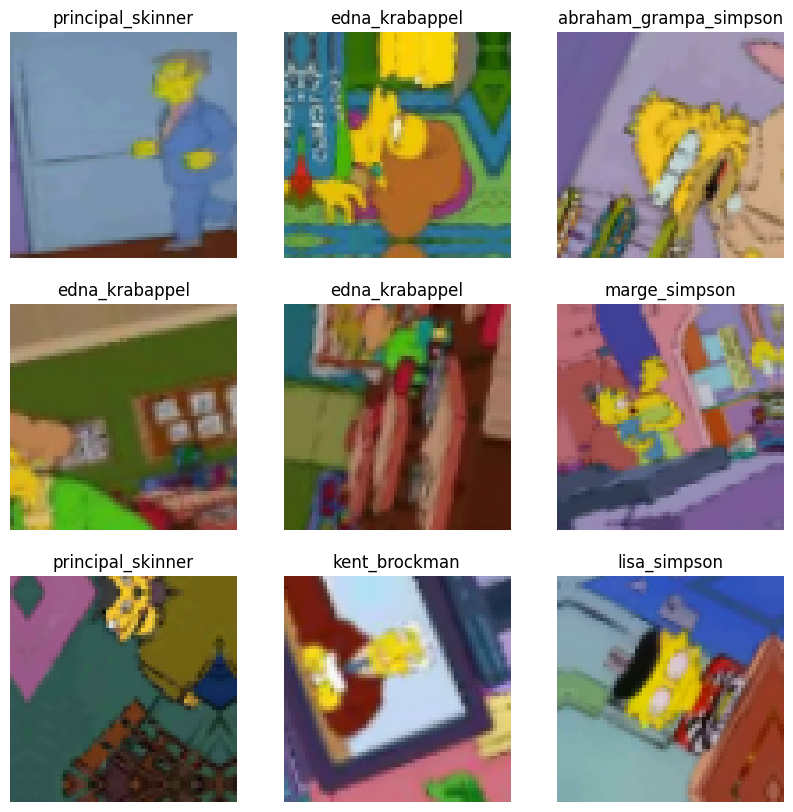

In [12]:
# Visualizar algunas imágenes y etiquetas
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Model

## Model CNN

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, Rescaling
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = Sequential([
    Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## ResNet50

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)
num_classes = len(class_names)

base_model = ResNet50(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.30)(x)
x = Dense(512, activation='relu')(x)  # Reducí un poco la capa densa para hacerlo más rápido
outputs = Dense(num_classes, activation='softmax')(x)
modelResNet50 = Model(inputs, outputs)

modelResNet50.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

modelResNet50.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 64, 64)    │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 64, 64)    │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 64, 64)    │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 64, 64, 3) │          0 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64, 3) │          0 │ stack[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2, 2,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  1,049,088 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 18)        │      9,234 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,646,034 (94.02 MB)

 Trainable params: 24,592,914 (93.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

##  Evaluación inicial



In [15]:
small_train_ds = train_ds.take(50)
small_val_ds = val_ds.take(20)

loss0, accuracy0 = model.evaluate(small_val_ds)
print(f"Initial loss: {loss0:.2f}")
print(f"Initial accuracy: {accuracy0:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 698ms/step - accuracy: 0.0599 - loss: 2.9027
Initial loss: 2.91
Initial accuracy: 0.06


## Callbacks

In [16]:
# Carpeta base con timestamp
log_dir = "/content/drive/MyDrive/DataSets/Deep/simpsons/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir, exist_ok=True)

# Subcarpetas para checkpoints y logs de tensorboard
checkpoint_dir = os.path.join(log_dir, "checkpoint")
tensorboard_log_dir = os.path.join(log_dir, "log")

os.makedirs(checkpoint_dir, exist_ok=True)

# Instanciar callbacks
callback = []

tensorboard_callback = TensorBoard(
    log_dir=tensorboard_log_dir, # Ruta para guardar perdida y presición.
    histogram_freq=1, # Cada epoca guarda los datos
    write_graph= True # Guarda la arquitectura del modelo
)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model_epoch.keras"),  # Ruta para guardar el mejor modelo
    monitor="val_accuracy",  # Monitorear la precisión de validación.
    save_best_only=True,  # Guardar solo el mejor modelo.
    save_weights_only=False,  # Guardar todo el modelo (no solo los pesos).
    verbose=1 # Mostrar texto.
)

early_stop_callback = EarlyStopping(
    monitor="val_loss", # Monitorear la pérdida de validación.
    patience=10, # Detener luego de 10 intentos sin mejora.
    restore_best_weights=True # Restaurar los pesos del mejor modelo.
)

callback.append(tensorboard_callback)
callback.append(checkpoint_callback)
callback.append(early_stop_callback)

## Entrenamiento

In [ ]:
start_time = time.time()

epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= epochs,
    callbacks=callback
)

end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos, {training_time/60:.2f} minutos")

# Mejor val_accuracy
print(f"Mejor val_accuracy: {np.max(history.history['val_accuracy']):.4f}")

Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3515 - loss: 2.1667
Epoch 1: val_accuracy improved from 0.07407 to 0.13102, saving model to /content/drive/MyDrive/DataSets/Deep/simpsons/20250523-000926/checkpoint/best_model_epoch.keras
173/173 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.3516 - loss: 2.1664 - val_accuracy: 0.1310 - val_loss: 4.1464
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4381 - loss: 1.9024
Epoch 2: val_accuracy improved from 0.13102 to 0.16944, saving model to /content/drive/MyDrive/DataSets/Deep/simpsons/20250523-000926/checkpoint/best_model_epoch.keras
173/173 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.4382 - loss: 1.9021 - val_accuracy: 0.1694 - val_loss: 4.2825
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5151 - loss: 1.6693
Epoch 3: val_accuracy improved from 0.16944 to 0.39352, saving model to /content/drive/MyDrive/DataSets/Deep/simpsons/20250523-000926/checkpoint/best_model_epoch.keras
173/1

# Resultados

## Graficar resultados

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()

# tensorboard

## TensorBoard CNN

In [ ]:
%load_ext tensorboard
log_dir = "/content/drive/MyDrive/DataSets/Deep/simpsons/20250522-174357/log"
%tensorboard --logdir "$log_dir"

## TensorBoard ResNet50

In [ ]:
%load_ext tensorboard
log_dir = "/content/drive/MyDrive/DataSets/Deep/simpsons/20250522-172634/log"
%tensorboard --logdir "$log_dir"

# Matriz correlación

## Matriz Validación

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, max_classes=18):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm[:max_classes, :max_classes]
    class_names = class_names[:max_classes]

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.title(f'Matriz de Confusión (primeras {max_classes} clases)')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# Obtener etiquetas reales de val_ds
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

# Predicciones
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mostrar matriz con las primeras 10 clases (o las que quieras)
plot_confusion_matrix(y_true, y_pred_classes, class_names, max_classes=18)

## Matriz Test

In [ ]:
preds = model.predict(X_t)
pred_classes = np.argmax(preds, axis=1)

# Comparar con etiquetas reales
from sklearn.metrics import classification_report
print(classification_report(y_t, pred_classes, target_names=list(MAP_CHARACTERS.values())))

# Gradio

## Añadir Gradio Video

In [ ]:
!pip install gradio --quiet

In [ ]:
import gradio as gr

IMG_SIZE = 64
model_path = "/content/drive/MyDrive/model/best_model_epoch.keras"

model = load_model(model_path)


MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


PERSIST_FRAMES = 15
CONF_THRESHOLD = 0.65  # 65% confianza mínima para mostrar etiqueta


def predict_character(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image, verbose=0)[0]
    top_indices = prediction.argsort()[-3:][::-1]
    best_id = top_indices[0]
    best_label = MAP_CHARACTERS[best_id]
    best_conf = prediction[best_id]
    return best_label, best_conf, top_indices, prediction


def is_near(box1, box2, threshold=50):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    center1 = (x1 + w1/2, y1 + h1/2)
    center2 = (x2 + w2/2, y2 + h2/2)
    dist = np.sqrt((center1[0]-center2[0])**2 + (center1[1]-center2[1])**2)
    return dist < threshold


def add_margin(box, margin, max_width, max_height):
    x, y, w, h = box
    x_new = max(0, x - margin)
    y_new = max(0, y - margin)
    w_new = min(w + 2*margin, max_width - x_new)
    h_new = min(h + 2*margin, max_height - y_new)
    return (x_new, y_new, w_new, h_new)


def process_video(video):
    input_path = video.name


    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise ValueError("No se pudo abrir el video.")


    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0 or width == 0 or height == 0:
        fps = 20


    temp_avi = tempfile.NamedTemporaryFile(delete=False, suffix=".avi")
    avi_path = temp_avi.name
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(avi_path, fourcc, fps, (width, height))


    if not out.isOpened():
        raise ValueError("No se pudo iniciar VideoWriter.")


    tracked_faces = []


    while True:
        ret, frame = cap.read()
        if not ret:
            break


        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)


        updated_tracked = []


        for (x, y, w, h) in faces:
            # Agregar margen para no cortar la cara
            x_m, y_m, w_m, h_m = add_margin((x, y, w, h), margin=10, max_width=width, max_height=height)
            roi = frame[y_m:y_m+h_m, x_m:x_m+w_m]


            try:
                label, conf, _, _ = predict_character(roi)


                if conf < CONF_THRESHOLD:
                    continue  # No dibujar si confianza baja


                matched = False
                for tf in tracked_faces:
                    if is_near((x_m, y_m, w_m, h_m), tf['box']):
                        tf['box'] = (x_m, y_m, w_m, h_m)
                        tf['label'] = label
                        tf['conf'] = conf
                        tf['frames_left'] = PERSIST_FRAMES
                        updated_tracked.append(tf)
                        matched = True
                        break
                if not matched:
                    updated_tracked.append({
                        'box': (x_m, y_m, w_m, h_m),
                        'label': label,
                        'conf': conf,
                        'frames_left': PERSIST_FRAMES
                    })
            except Exception as e:
                print(f"Error en predicción: {e}")


        # Mantener caras no detectadas pero aún visibles (persistencia)
        for tf in tracked_faces:
            if tf not in updated_tracked:
                tf['frames_left'] -= 1
                if tf['frames_left'] > 0:
                    updated_tracked.append(tf)


        # Dibujar etiquetas
        for tf in updated_tracked:
            x, y, w, h = map(int, tf['box'])
            label = tf['label']
            conf = tf['conf']
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, f"{label} ({conf*100:.1f}%)", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)


        tracked_faces = updated_tracked
        out.write(frame)


    cap.release()
    out.release()


    # Convertir AVI a MP4 para compatibilidad
    temp_mp4 = tempfile.NamedTemporaryFile(delete=False, suffix=".mp4")
    mp4_path = temp_mp4.name


    import subprocess
    ffmpeg_command = [
        'ffmpeg', '-y', '-i', avi_path,
        '-vcodec', 'libx264',
        '-pix_fmt', 'yuv420p',
        mp4_path
    ]
    subprocess.run(ffmpeg_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


    return mp4_path


iface = gr.Interface(
    fn=process_video,
    inputs=gr.File(label="Sube un video MP4", file_types=[".mp4"]),
    outputs=gr.Video(label="Video procesado"),
    title="🎬 Clasificador Mejorado de Simpsons en Video",
    description="Detecta rostros, aplica modelo probado con imágenes y filtra predicciones con baja confianza."
)


iface.launch(share=True, debug=True)

##Gradio imágen##

In [ ]:
import gradio as gr
import numpy as np
import cv2
from tensorflow.keras.models import load_model


# 3. Ruta del modelo entrenado en tu Drive
model_path = "/content/drive/MyDrive/DataSets/Deep/simpsons/20250515-212121/checkpoint/best_model_epoch.keras"
model = load_model(model_path)


# 4. Diccionario de mapeo de clases
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}


IMG_SIZE = 64  # Tamaño estándar del modelo


# 5. Función de predicción
def predict_character(image):
    # Gradio ya entrega imagen RGB como NumPy array (no usar cv2.imread ni cvtColor)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Solo redimensionar
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)


    prediction = model.predict(image)[0]
    top_indices = prediction.argsort()[-3:][::-1]


    result = "Top 3 predicciones:\n"
    for i in top_indices:
        nombre = MAP_CHARACTERS[i]
        prob = prediction[i] * 100
        result += f"{nombre}: {prob:.2f}%\n"
    return result




# 6. Crear interfaz Gradio
interface = gr.Interface(
    fn=predict_character,
    inputs=gr.Image(type="numpy", label="Sube una imagen de un personaje"),
    outputs="text",
    title="🧠 Clasificador de Personajes de Los Simpsons",
    description="Carga una imagen y el modelo CNN predirá el personaje más probable."
)


# 7. Lanzar Gradio
interface.launch(share=True)  # Puedes cambiar share=False si no quieres link externo